<h3>Digit Highlighter</h3>

We will make a simple application to read in a series of handwritten or typed digits in an image and automatically classify what each digit is.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read in grayscale image.

In [2]:
im = cv2.imread('phone_number.jpg',0)

Resize image

In [3]:
scale = .1
w = int(im.shape[1] * scale)
h = int(im.shape[0] * scale)
dim = (w, h)
  
im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)


Plot image.

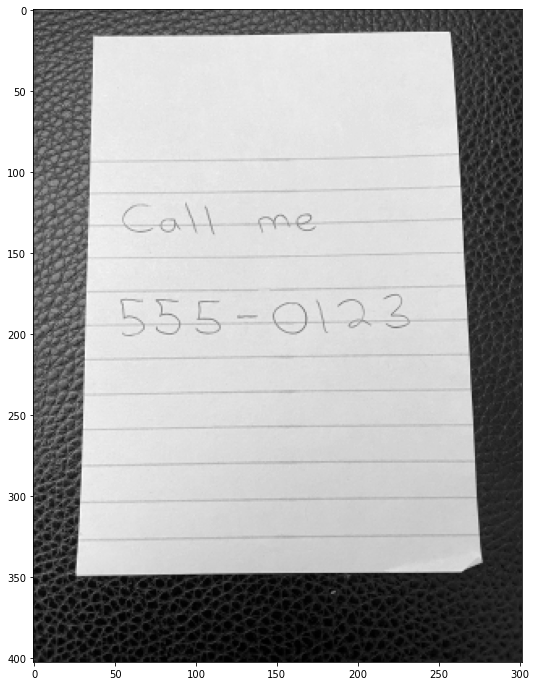

In [4]:
plt.figure(figsize=(15,12))
plt.imshow(im,cmap='gray')

We will only focus on classifying the digits but the workflow would be the same for the characters. At first we will get rid of the horizontal lines on the note. 

Begin with adaptive Gaussian thresholding.

In [5]:
thresh = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY_INV,45,5)

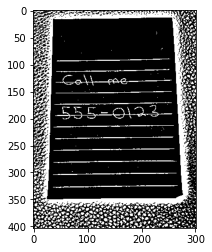

In [6]:
plt.imshow(thresh,cmap='gray')

Now we will attempt to remove horizontal lines on the note.

In [7]:
# Create a horizontal kernel to perform morphological opening and isolate lines of a certain length.

h_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (25,1))
lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, h_kernel, iterations=1)
cnts = cv2.findContours(lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for c in cnts[0]:
    cv2.drawContours(thresh, [c], -1, 255, 1)

Draw horizontal lines detected on blank mask image.

In [8]:
mask = np.zeros(thresh.shape, np.uint8)
for c in cnts[0]:
    cv2.drawContours(mask, [c], -1, (255,255,255), 2)

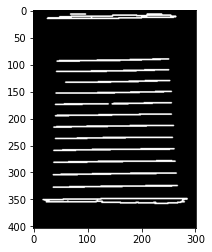

In [9]:
plt.imshow(mask,cmap='gray')

Subtract thresholded image from mask image to remove horizontal lines.

In [10]:
fin = cv2.subtract(thresh,mask)

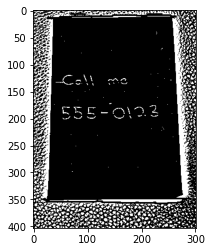

In [11]:
plt.imshow(fin,cmap='gray')

Set region of interest as the phone number in the image.

In [12]:
image = fin[170:210,50:250]

In [13]:
nums = image.copy()

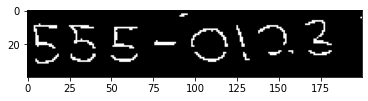

In [14]:
plt.imshow(nums,cmap='gray')

Perform morphological closing to merge gaps.

In [15]:
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(nums, cv2.MORPH_CLOSE, kernel)

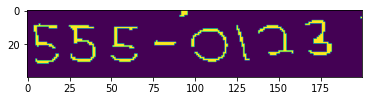

In [16]:
plt.imshow(closing)

Now we dilate and erode separately to further merge holes in the image.

In [23]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
dilate = cv2.dilate(closing, kernel , iterations=2)

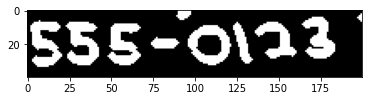

In [24]:
plt.imshow(dilate,cmap='gray')

In [25]:
erode = cv2.erode(dilate,kernel,iterations=1)

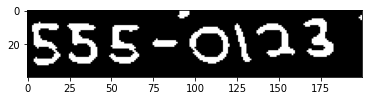

In [26]:
plt.imshow(erode,cmap='gray')

Find contours in eroded image.

In [27]:
cnts,hierarchy= cv2.findContours(erode.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Only keep valid contours.

In [28]:
real=[]
for i in range(1,len(hierarchy[0])):
    if hierarchy[0][i][3]==-1:
        real.append(i)

In [29]:
real = np.array(real)

Only keep contours that meet the size requirement.

In [30]:
contours = []

min_area = 50
max_area = 1000

for c in [cnts[i] for i in real]:
    x,y,w,h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    if area > min_area and area<max_area:
        cv2.rectangle(im[170:210,50:250], (x,y), (x+w, y+h), (0,255,0),1)
        contours.append(c)

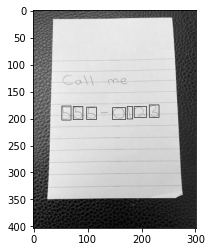

In [31]:
plt.imshow(im,cmap='gray') 

In [32]:
rois = []

# Append regions within the bounding boxes to the rois list.

for c in [cnts[i] for i in real]:
    x,y,w,h = cv2.boundingRect(c)
    area = cv2.contourArea(c)
    if area > min_area and area<max_area:
        rois.append(erode[y:y+h,x:x+w])

Rearrange detected contours to go from left to right by finding the x centroids. Can also incorporate y centroids to go from top down.

In [34]:
cont_list=[]
for c in [cnts[i] for i in real]:
    area = cv2.contourArea(c)
    if area > min_area and area<max_area:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cont_list.append(cX)

In [35]:
order = {x:i for i,x in enumerate(cont_list)}

View all contours as $28 \times 28$ images just as in the MNIST data.

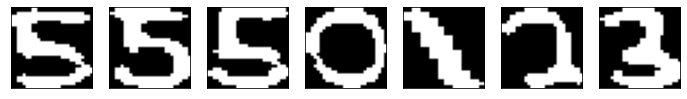

In [36]:
fig, axs = plt.subplots(1, len(cont_list),figsize=(12,8))


for i in range(len(cont_list)):
    j = cv2.resize(rois[order[sorted(order.keys())[i]]], (28,28), interpolation = cv2.INTER_NEAREST)
    axs[i].imshow(j,cmap='gray')
    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

<hr style="height:5px">

We now employ the MNIST data set to train a network in order to classify these digits. However, the digits we have above don't align well with digits from MNIST due to the lack of a border around the digit. Therefore, we add a border to each tile and then resize it to the appropriate size to classify.

In [37]:
resized_nums = []
for i in range(len(cont_list)):
    IM = rois[order[sorted(order.keys())[i]]]
    border = cv2.copyMakeBorder(
    IM,
    top=10,
    bottom=10,
    left=10,
    right=10,
    borderType=cv2.BORDER_CONSTANT,
    value=[0, 0, 0]
)
    fin = cv2.resize(border,(28,28),interpolation = cv2.INTER_NEAREST)
    resized_nums.append(fin)

Check results on sample digit.

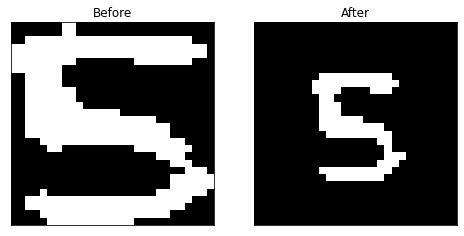

In [38]:
fig, axs = plt.subplots(1, 2,figsize=(8,4))



axs[0].imshow(cv2.resize(rois[order[sorted(order.keys())[0]]], (28,28), interpolation = cv2.INTER_NEAREST),cmap='gray')
axs[1].imshow(resized_nums[0],cmap='gray')
axs[0].set_title('Before')
axs[1].set_title('After')
    
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

Looks much better. We can move on to training and classifying. We will use much of the keras code as well the network parameters from "Deep Learning with Python" by Francois Chollet.

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

Load and preprocess MNIST data.

In [43]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [44]:
model = keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(20,activation='relu'),
        layers.Dense(10, activation="softmax")
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)               

Won't spend much time on training as 1 epoch should be fine for our purposes.

In [45]:
batch_size = 128
epochs = 1

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Train on 60000 samples
60000/60000 [==============================] - 104s 2ms/sample - loss: 0.2959 - accuracy: 0.9074 - loss: 0.2987 - ac


Process the border adjusted and resized contours from the note.

In [46]:
resized_nums = np.array(resized_nums)

resized_nums = resized_nums.astype("float32") / 255

Append the predicted digits to a list and print the full phone number.

In [50]:
phone_number = []
for i in range(len(resized_nums)):
    phone_number.append(str(np.argmax(model.predict(resized_nums[i].reshape(1,28,28,1)))))

In [51]:
ans = ''.join(phone_number)

In [52]:
print('The phone number is: {} '.format(ans))

The phone number is: 5550123 
